In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
inspector = inspect(engine)

columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
# Calculate the date 1 year ago from the last data point in the database
lst_dt = dt.datetime.strptime((session.query(Measurement.date).\
                                 order_by(Measurement.date.desc()).first()[0]), '%Y-%m-%d')
lst_yr = lst_dt - dt.timedelta(days=365)

([], <a list of 0 Text xticklabel objects>)

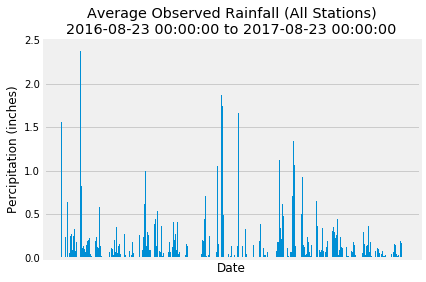

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
data_df = pd.DataFrame(session.query(Measurement.date, Measurement.station, Measurement.prcp,\
                                     Measurement.tobs).\
    filter(Measurement.date.between(lst_yr, lst_dt)).\
    order_by(Measurement.date.desc()).all())

data_grp = data_df.groupby('date').mean()
plt.bar(list(data_grp.index), data_grp['prcp'])
plt.title(f'''Average Observed Rainfall (All Stations)
{lst_yr} to {lst_dt}''')
plt.xlabel('Date')
plt.ylabel('Percipitation (inches)')
plt.xticks([])

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
data_df.describe()

,prcp,tobs
count,2015.000000,2223.000000
mean,0.176462,74.578947
std,0.460288,4.612232
min,0.000000,58.000000
25%,0.000000,71.000000
50%,0.020000,75.000000
75%,0.130000,78.000000
max,6.700000,87.000000


In [15]:
# Design a query to show how many stations are available in this dataset?
session.query(Measurement.station).group_by(Measurement.station).count()

9

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.tobs)).\
group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
top_stn = session.query(Measurement.station).group_by(Measurement.station).\
order_by(func.count(Measurement.tobs).desc()).first()[0]

avg_tmp = session.query(func.avg(Measurement.tobs)).\
filter(Measurement.station == top_stn).first()[0]

max_tmp = session.query(func.max(Measurement.tobs)).\
filter(Measurement.station == top_stn).first()[0]

min_tmp = session.query(func.min(Measurement.tobs)).\
filter(Measurement.station == top_stn).first()[0]

print(f"""Temperature at Station ID: {top_stn}
Min Temp: {min_tmp}
Max Temp: {max_tmp}
Avg Temp: {avg_tmp}
""")

Temperature at Station ID: USC00519281
Min Temp: 54.0
Max Temp: 85.0
Avg Temp: 71.66378066378067



<function matplotlib.pyplot.show(*args, **kw)>

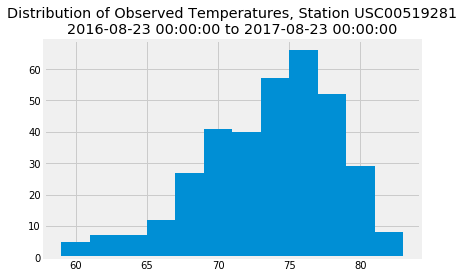

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
top_tobs = session.query(Measurement.tobs).\
    filter(Measurement.date.between(lst_yr, lst_dt)).\
    filter(Measurement.station == top_stn).all()

top_tobs_ls = []
i = 0
for x in top_tobs:
    top_tobs_ls.append(top_tobs[i][0])
    i += 1

plt.hist(top_tobs_ls, bins=12)
plt.title(f'''Distribution of Observed Temperatures, Station {top_stn}
{lst_yr} to {lst_dt}''')

plt.show

![precipitation](Images/station-histogram.png)

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
lst_yr_str = dt.datetime.strftime(lst_yr, '%Y-%m-%d')
lst_dt_str = dt.datetime.strftime(lst_dt, '%Y-%m-%d')
calc_temps_ls = calc_temps(lst_yr_str, lst_dt_str)

calc_temps_ls[0]

(58.0, 74.59058295964125, 87.0)

Text(0.5, 1.0, 'Trip Average Temperature')

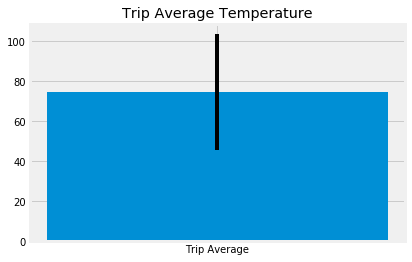

In [21]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.bar(['Trip Average'], calc_temps_ls[0][1], yerr=(calc_temps_ls[0][0] - calc_temps_ls[0][2]), width=0.1)
plt.title('Trip Average Temperature')

Precipitation Analysis

Design a query to retrieve the last 12 months of precipitation data.
Select only the date and prcp values.
Load the query results into a Pandas DataFrame and set the index to the date column.
Sort the DataFrame values by date.
Plot the results using the DataFrame plot method.

In [22]:
# Calculate the total amount of rainfall per weather station for your trip 
# dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and 
# list the station, name, latitude, longitude, and elevation


def calc_rain(start_date, end_date):

    return session.query(func.sum(Measurement.prcp).label('total rainfall'), Measurement.station,\
                        Station.name, Station.latitude, Station.longitude, Station.elevation).\
            group_by(Measurement.station).filter(Measurement.date >= start_date).\
            filter(Measurement.date <= end_date).join(Station, Measurement.station==Station.station).all()


vayc_start_dt = dt.datetime.strptime(('2017-06-07'), ('%Y-%m-%d'))

vatc_end_dt = vayc_start_dt + dt.timedelta(days=10)

trip_df = pd.DataFrame(calc_rain('2017-06-09',vatc_end_dt))

trip_df


,total rainfall,station,name,latitude,longitude,elevation
0,1.83,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
1,1.67,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
2,4.86,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
3,NaN,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,2.76,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
5,0.14,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
6,0.61,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5


## Optional Challenge Assignment

In [23]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [24]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [25]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [26]:
# Plot the daily normals as an area plot with `stacked=False`
